## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

Understand the results of an A/B test run by an e-commerce website. Goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [49]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read in the dataset and take a look at the top few rows here:

In [50]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Use the below cell to find the number of rows in the dataset.

In [51]:
df.shape

(294478, 5)

The number of unique users in the dataset.

In [52]:
df.user_id.nunique()

290584

The proportion of users converted.

In [53]:
df.converted.mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [54]:
df.query('landing_page=="new_page" and group=="treatment"').shape[0]

145311

In [55]:
df.query('landing_page=="old_page" and group=="control"').shape[0]

145274

In [56]:
df.shape[0] - df.query('landing_page=="new_page" and group=="treatment"').shape[0] - df.query('landing_page=="old_page" and group=="control"').shape[0]

3893

Do any of the rows have missing values?

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. Remove the rows where **landing_page** and **group** dont match up

Store your new dataframe in **df2**.

In [58]:
new_page = df.query('group=="treatment" and landing_page=="new_page"')
old_page = df.query('group=="control" and landing_page=="old_page"')
df2 = new_page.append(old_page,ignore_index = True)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [59]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [60]:
df2.shape[0]

290585

In [61]:
df2.user_id.nunique()

290584

There is one **user_id** repeated in **df2**. 

In [62]:
df2[df2.duplicated(['user_id'], keep=False)]


,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


the row information for the repeat **user_id**

In [63]:
df2[df2.duplicated(['user_id'], keep=False)]


,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [64]:
df2.drop(df2.index[1404],inplace = True)

In [65]:
df2.shape[0]

290584

In [66]:
df2.user_id.nunique()

290584

`4.` a. What is the probability of an individual converting regardless of the page they receive?

In [67]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [68]:
df2.query('group=="control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [69]:
df2.query('group=="treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [70]:
df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**Results of question 4b and 4c suggests us that there is a small difference in conversion where there are more people getting converted in the control group. But there are chances that the situation may go the opposite way anytime.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

                **p_new <= p_old**

                **p_new > p_old**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. 

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br>
Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [71]:
p_new = df2.converted.mean()


In [72]:
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [73]:
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$?

In [74]:
n_new = df2.query('landing_page=="new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [75]:
n_old = df2.query('landing_page=="old_page"').shape[0]
n_old

145274

In [76]:
p_null = p_new

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [77]:
 new_page_converted = np.random.binomial(1, p_null, n_new)


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [78]:
 old_page_converted = np.random.binomial(1, p_null, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [79]:
new_page_converted.mean() - old_page_converted.mean()

0.00028034693976085323

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [80]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.binomial(1, p_null, n_new)
    old_page_converted = np.random.binomial(1, p_null, n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**. 

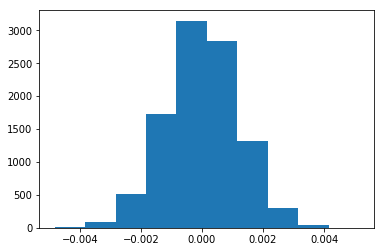

In [81]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [83]:
obs_diff = df2.query('landing_page=="new_page"').converted.mean() - df2.query('landing_page=="old_page"').converted.mean()
(p_diffs > obs_diff).mean()

0.9083

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**This p-value helps us in choosing the null/alternative hypothesis based on the threshold limit of error**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [84]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page"').converted.sum()
convert_new = df2.query('landing_page=="new_page"').converted.sum()
n_old = 145274
n_new = 145310

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [85]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [145274, 145310])


In [86]:
z_score , p_value

(1.3109241984234394, 0.18988337448195103)

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, type of regression should you be performed here in this case is :

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [87]:
df2[['control','treatment']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,control,treatment
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,0,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,0,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,0,1


In [92]:
df2['ab_page'] = df2['treatment']
df2.drop('treatment',axis=1,inplace=True)
df2.drop('control',axis=1,inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1
5,929503,2017-01-18 05:37:11.527370,treatment,new_page,0,1
6,834487,2017-01-21 22:37:47.774891,treatment,new_page,0,1


c. Use statsmodels to import your regression model. Instantiate the model, and fit the model using the two columns you created in part b. to predict whether or not an individual converts.

In [96]:
df2['intercept'] = 1
df2[['new_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,new_page,old_page
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1,0
5,929503,2017-01-18 05:37:11.527370,treatment,new_page,0,1,1,1,0
6,834487,2017-01-21 22:37:47.774891,treatment,new_page,0,1,1,1,0


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [97]:
log_mod = sm.Logit(df2['converted'],df2[['intercept','new_page','ab_page']])
results = log_mod.fit()
results.summary()

         Current function value: 0.366120
         Iterations: 35


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290582
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            1
Date:                Thu, 20 Dec 2018   Pseudo R-squ.:               8.060e-06
Time:                        16:07:00   Log-Likelihood:            -1.0639e+05
converged:                      False   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1903
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
new_page      -0.0075   7.04e+05  -1.06e-08      1.000   -1.38e+06    1.38e+06
ab_page       -0.0075   7.04e+05  -1.06e-08      1.000   -1.38e+06    1.38e+06
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

**p-value = 1.Part iii is a two-tailed test and Part ii is a one-tail test**

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])